In [979]:
import pandas as pd
import random
import numpy as np
from xgboost import XGBClassifier
from xgboost import train
from xgboost import DMatrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm

from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import warnings
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import datetime
from dateutil.rrule import rrule, DAILY

In [2]:
import shap
shap.initjs()
output_notebook()

Loading BokehJS ...

In [264]:
file = pd.read_csv("C:/Users/p0p/Desktop/anaomaly\London carbon/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/Power-Networks-LCL-June2015(withAcornGps)v2_135.csv")

In [265]:
file.columns

Index(['LCLid', 'stdorToU', 'DateTime', 'KWH/hh (per half hour) ', 'Acorn',
       'Acorn_grouped'],
      dtype='object')

In [266]:
file = file.replace('Null', 0)

In [267]:
file['KWH/hh (per half hour) '] = pd.to_numeric(file['KWH/hh (per half hour) '])

In [278]:
file['DateTime'] = pd.to_datetime(file['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')

In [279]:
file = file.rename({"KWH/hh (per half hour) ": "kwh"},axis='columns')

In [277]:
file['KWH/hh (per half hour) '].dtype

dtype('float64')

In [275]:
file[file['stdorToU'] == 'ToU'].LCLid.unique()[0]

'MAC000005'

In [615]:
file_copy = file.copy()

In [311]:
k = file[(file['LCLid'] == 'MAC000005')]

In [334]:
k.drop_duplicates(inplace=True)

In [456]:
k[k['DateTime'].dt.date == datetime.date(2012, 11, 12)].DateTime
# 2012-11-12

156510   2012-11-12 00:00:00
156511   2012-11-12 00:30:00
156512   2012-11-12 01:00:00
156513   2012-11-12 01:30:00
156514   2012-11-12 02:00:00
156515   2012-11-12 02:30:00
156516   2012-11-12 03:00:00
156517   2012-11-12 03:30:00
156518   2012-11-12 04:00:00
156519   2012-11-12 04:30:00
156520   2012-11-12 05:00:00
156521   2012-11-12 05:30:00
156522   2012-11-12 06:00:00
156523   2012-11-12 06:30:00
156524   2012-11-12 07:00:00
156525   2012-11-12 07:30:00
156526   2012-11-12 08:00:00
156527   2012-11-12 08:30:00
156528   2012-11-12 09:00:00
156529   2012-11-12 09:30:00
156530   2012-11-12 10:00:00
156531   2012-11-12 10:30:00
156532   2012-11-12 11:00:00
156533   2012-11-12 11:30:00
156534   2012-11-12 12:00:00
156535   2012-11-12 12:30:00
156536   2012-11-12 13:00:00
156537   2012-11-12 13:30:00
156538   2012-11-12 14:00:00
156539   2012-11-12 14:30:00
156540   2012-11-12 15:00:00
156541   2012-11-12 15:30:00
156542   2012-11-12 16:00:00
156543   2012-11-12 16:30:00
156544   2012-

In [552]:
sub = k[k['DateTime'].dt.date == datetime.date(2012, 11, 12)]

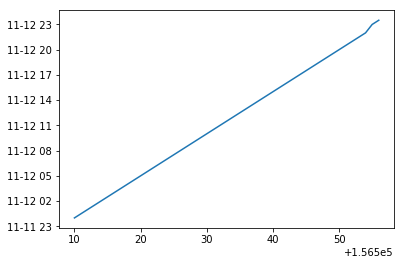

In [550]:
sub.DateTime.plot()

In [541]:
if (sub.DateTime.diff().dt.seconds > 1800).any():
    print(sub[sub.DateTime.diff().dt.seconds > 1800].DateTime.index)
# sub[(sub.DateTime.diff().dt.seconds < 1800)

Int64Index([156555], dtype='int64')


In [547]:
ixx = (sub[sub.DateTime.diff().dt.seconds > 1800].DateTime.index)[0]

In [565]:
c_no = file[file['stdorToU'] == 'ToU'].LCLid.unique()

In [566]:
k = file[(file['LCLid'] == c_no[8])]

In [610]:
itd = (k[k['DateTime'].dt.date == datetime.date(2011, 12, 6)]).index.astype(int)

In [614]:
k.drop(itd, inplace = True)

In [632]:
k = file[(file['LCLid'] == c_no[2])]
start_date = k.iloc[0].DateTime.date()
end_date = k.iloc[-1].DateTime.date()
for dat in rrule(DAILY, dtstart=start_date, until=end_date):
    sub = k[k['DateTime'].dt.date == dat.date()]
    days =  sub.kwh.shape[0]
    if days != 48:
        print(dat, days)
        itd = (k[k['DateTime'].dt.date == dat.date()]).index.astype(int)
        k.drop(itd, inplace = True)

2011-12-06 00:00:00 22
2011-12-15 00:00:00 49
2012-01-15 00:00:00 49
2012-02-15 00:00:00 49
2012-03-17 00:00:00 49
2012-04-05 00:00:00 46
2012-04-17 00:00:00 49
2012-05-18 00:00:00 49
2012-06-18 00:00:00 49
2012-06-28 00:00:00 47
2012-07-19 00:00:00 49
2012-08-19 00:00:00 49
2012-09-19 00:00:00 49
2012-10-16 00:00:00 47
2012-10-20 00:00:00 49
2012-11-20 00:00:00 49
2012-12-18 00:00:00 49
2012-12-21 00:00:00 49
2012-12-24 00:00:00 47
2013-01-18 00:00:00 47
2013-01-21 00:00:00 49
2013-02-03 00:00:00 47
2013-02-11 00:00:00 47
2013-02-17 00:00:00 43
2013-02-21 00:00:00 49
2013-03-24 00:00:00 49
2013-04-04 00:00:00 47
2013-04-24 00:00:00 49
2013-05-25 00:00:00 49
2013-06-25 00:00:00 49
2013-07-26 00:00:00 49
2013-08-26 00:00:00 49
2013-09-01 00:00:00 47
2013-09-24 00:00:00 47
2013-09-26 00:00:00 49
2013-10-27 00:00:00 49
2013-10-28 00:00:00 42
2013-11-07 00:00:00 42
2013-11-27 00:00:00 49
2013-12-28 00:00:00 49
2014-01-08 00:00:00 44
2014-01-09 00:00:00 46
2014-01-28 00:00:00 49
2014-02-28 

In [633]:
for dat in rrule(DAILY, dtstart=start_date, until=end_date):
    sub = k[k['DateTime'].dt.date == dat.date()]
    days =  sub.kwh.shape[0]
    if days != 48:
        print(dat, days)

2011-12-06 00:00:00 0
2011-12-15 00:00:00 0
2012-01-15 00:00:00 0
2012-02-15 00:00:00 0
2012-03-17 00:00:00 0
2012-04-05 00:00:00 0
2012-04-17 00:00:00 0
2012-05-18 00:00:00 0
2012-06-18 00:00:00 0
2012-06-28 00:00:00 0
2012-07-19 00:00:00 0
2012-08-19 00:00:00 0
2012-09-19 00:00:00 0
2012-10-16 00:00:00 0
2012-10-20 00:00:00 0
2012-11-20 00:00:00 0
2012-12-18 00:00:00 0
2012-12-21 00:00:00 0
2012-12-24 00:00:00 0
2013-01-18 00:00:00 0
2013-01-21 00:00:00 0
2013-02-03 00:00:00 0
2013-02-11 00:00:00 0
2013-02-17 00:00:00 0
2013-02-21 00:00:00 0
2013-03-24 00:00:00 0
2013-04-04 00:00:00 0
2013-04-24 00:00:00 0
2013-05-25 00:00:00 0
2013-06-25 00:00:00 0
2013-07-26 00:00:00 0
2013-08-26 00:00:00 0
2013-09-01 00:00:00 0
2013-09-24 00:00:00 0
2013-09-26 00:00:00 0
2013-10-27 00:00:00 0
2013-10-28 00:00:00 0
2013-11-07 00:00:00 0
2013-11-27 00:00:00 0
2013-12-28 00:00:00 0
2014-01-08 00:00:00 0
2014-01-09 00:00:00 0
2014-01-28 00:00:00 0
2014-02-28 00:00:00 0


In [637]:
tariff = pd.read_excel("C:/Users/p0p/Desktop/anaomaly/London carbon/tariffs.xlsx")

In [657]:
tstart = tariff.iloc[0]['TariffDateTime'].date()
tend = tariff.iloc[-1]['TariffDateTime'].date()
for dat in rrule(DAILY, dtstart=tstart, until=tend):
    sub = k[k['DateTime'].dt.date == dat.date()]

In [690]:
tariff.replace(['Normal','High', 'Low'], [0,1,-1], inplace = True)

In [709]:
a = (k[k['DateTime'].dt.date == datetime.date(2013, 1,30)].kwh.values)
b = (tariff[tariff['TariffDateTime'].dt.date == datetime.date(2013, 1,30)].Tariff.values)

In [715]:
(k[k['DateTime'].dt.date == datetime.date(2013, 2,17)].kwh.values)

array([], dtype=float64)

[<matplotlib.lines.Line2D at 0x19803d572e8>]

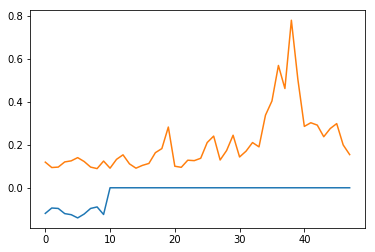

In [714]:
plt.plot(a*b)
plt.plot(a)

[<matplotlib.lines.Line2D at 0x1980339b080>]

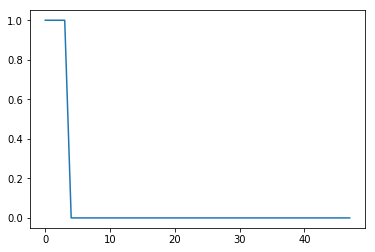

In [699]:
plt.plot(tariff[tariff['TariffDateTime'].dt.date == datetime.date(2013, 1,17)].Tariff.values)

In [940]:
X.shape,y.shape

((2064, 48), (2408,))

In [743]:
sub = k[k['DateTime'].dt.date == tstart]

In [945]:
c_no.shape

(24,)

In [982]:
def ccnc(i):
    customer_meter = c_no[i]
    k = file[(file['LCLid'] == c_no[i])]
    score = 0
    total = 0
    kappa = 0
    X = np.array([]).reshape(0,48)
    y = np.array([])
#     clf = XGBClassifier()
    clf = SVC(kernel='rbf',probability=True)
    clf = LGBMClassifier()
    #clf = SVC(kernel='rbf',probability=True)
    j = 0
    print(c_no[i])
    for dat in rrule(DAILY, dtstart=tstart, until=tend):
        sub = k[k['DateTime'].dt.date == dat.date()]
        if sub.shape[0] == 48:
            p = (random.randint(1,10))/10
            b=sub.kwh.values.reshape(-1,48)
            t1 =  np.array([x * p for x in b])
            t2 = np.array([z * (random.randint(1,9))/10 for z in b[0]]).reshape(-1,48)
            t3 = np.array([y * (random.randint(0,1)) for y in b[0]]).reshape(-1,48)
            t4 =  np.array([np.mean(b)*(random.randint(1,10))/10 for z in b[0]]).reshape(-1,48)
            t5 =  np.array([np.mean(b) for t in b[0]]).reshape(-1,48)
            t6 = b[::-1]
            b.shape,t1.shape,t2.shape,t3.shape,t4.shape,t5.shape,t6.shape
            #         b = np.append(b,[(b.mean()),b.std()])
            #         t1 = np.append(t1,[t1.mean(),t1.std()])
            #         t2 = np.append(t2,[t2.mean(),t2.std()])
            #         t3 = np.append(t3,[t3.mean(),t3.std()])
            #         t4 = np.append(t4,[t4.mean(),t4.std()])
            #         t5 = np.append(t5,[t5.mean(),t5.std()])
            #         t6 = np.append(t6,[t6.mean(),t6.std()])
            X= np.concatenate((X, b,t1,t2,t3,t4,t5,t6), axis=0)
            y = np.append(y,0)
            for i in range(0,6):   
                y = np.append(y,1)
        else:
            continue
#     print(X.shape,y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.14, random_state=0)
    sm = SMOTE(random_state=42)
    X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
    X_res_test, y_res_test = sm.fit_sample(X_test, y_test)
    clf.fit(X_res_train, y_res_train)
    score = clf.score(X_res_test, y_res_test)
    #print(Counter(y),Counter(y_train),Counter(y_test),Counter(y_res_train),Counter(y_res_test))
    #print("The score for customer :", customer_input, " is ",  score)
    y_pred = clf.predict(X_res_test)
    probs = clf.predict_proba(X_res_test)
    preds = probs[:,1]
    tn, fp, fn, tp = confusion_matrix(y_res_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity =  tp/ (tp+fn)
    fpr =  1 - specificity
    print ("sensi = %.2f" %sensitivity, "fpr= %.2f" % fpr )
    total =sensitivity
    print("The score for customer :", customer_meter, " is %.2f" %  total)
    return sensitivity,fpr,X_res_test, y_res_test,y_pred

In [983]:
sensitivity,fpr,X_res_test, y_res_test,y_pred = ccnc(15)

MAC000082
sensi = 0.77 fpr= 0.27
The score for customer : MAC000082  is 0.77


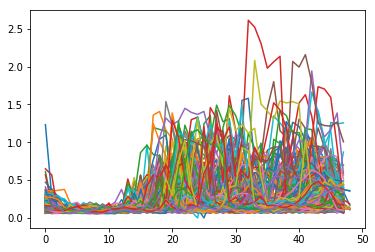

In [1022]:
for dat in rrule(DAILY, dtstart=tstart, until=tend):
        sub = k[k['DateTime'].dt.date == dat.date()]
        plt.plot(sub.kwh.values)

In [999]:
s = y_pred == y_res_test

[<matplotlib.lines.Line2D at 0x198050ceda0>]

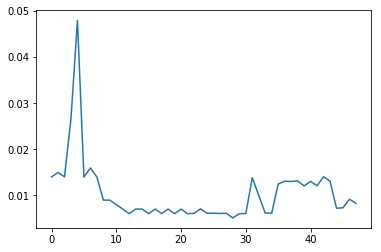

In [1019]:
plt.plot(X_res_test[~s][125])

In [1011]:
for i in range(0,X_res_test[~s].shape[0]):
    X_res_test[~s][i]

array([0.052, 0.053, 0.017, 0.028, 0.054, 0.048, 0.045, 0.042, 0.04 ,
       0.04 , 0.04 , 0.039, 0.04 , 0.038, 0.039, 0.039, 0.039, 0.039,
       0.039, 0.038, 0.039, 0.039, 0.039, 0.039, 0.038, 0.074, 0.451,
       0.446, 0.041, 0.038, 0.039, 0.039, 0.038, 0.038, 0.038, 0.298,
       0.134, 0.051, 0.051, 0.051, 0.025, 0.015, 0.019, 0.014, 0.015,
       0.015, 0.051, 0.059])

In [978]:
# MAC000014
# sensi = 0.82 fpr= 0.15
# The score for customer : MAC000014  is 0.82
# MAC000015
# sensi = 0.78 fpr= 0.08
# The score for customer : MAC000015  is 0.78
# MAC000017
# sensi = 0.82 fpr= 0.09
# The score for customer : MAC000017  is 0.82
# MAC000031
# sensi = 0.77 fpr= 0.11
# The score for customer : MAC000031  is 0.77
# MAC000044
# sensi = 0.79 fpr= 0.11
# The score for customer : MAC000044  is 0.79
# MAC000046
# sensi = 0.76 fpr= 0.09
# The score for customer : MAC000046  is 0.76
# MAC000048
# sensi = 0.75 fpr= 0.14
# The score for customer : MAC000048  is 0.75
# MAC000051
# sensi = 0.79 fpr= 0.14
# The score for customer : MAC000051  is 0.79
# MAC000052
# sensi = 0.76 fpr= 0.16
# The score for customer : MAC000052  is 0.76
# MAC000064
# sensi = 0.77 fpr= 0.12
# The score for customer : MAC000064  is 0.77
# MAC000065
# sensi = 0.79 fpr= 0.12
# The score for customer : MAC000065  is 0.79
# MAC000071
# sensi = 0.81 fpr= 0.47
# The score for customer : MAC000071  is 0.81
# MAC000075
# sensi = 0.75 fpr= 0.19
# The score for customer : MAC000075  is 0.75
# MAC000076
# sensi = 0.81 fpr= 0.14
# The score for customer : MAC000076  is 0.81
# MAC000082
# sensi = 0.74 fpr= 0.14
# The score for customer : MAC000082  is 0.74
# MAC000088
# sensi = 0.79 fpr= 0.14
# The score for customer : MAC000088  is 0.79
# MAC000106
# sensi = 0.78 fpr= 0.09
# The score for customer : MAC000106  is 0.78
# MAC000107
# sensi = 0.79 fpr= 0.08
# The score for customer : MAC000107  is 0.79
# MAC000109
# sensi = 0.81 fpr= 0.10
# The score for customer : MAC000109  is 0.81

# SVM
# MAC000014
# sensi = 0.72 fpr= 0.13
# The score for customer : MAC000014  is 0.72
# MAC000015
# sensi = 0.69 fpr= 0.25
# The score for customer : MAC000015  is 0.69

In [981]:
dr,fpr = 0,0
for i in range(1,3):
    a,b = ccnc(i)
    dr,fpr = dr + a, fpr +b

MAC000014
sensi = 0.82 fpr= 0.28
The score for customer : MAC000014  is 0.82
MAC000015
sensi = 0.78 fpr= 0.34
The score for customer : MAC000015  is 0.78


In [975]:
dr/19,fpr/19

(0.7827174717426931, 0.14080185447778792)

In [794]:
temp[::-1].shape

(1, 48)

In [716]:
# for j in range(0,len(c_no)):
#     print(c_no[j])
#     k = file[(file['LCLid'] == c_no[j])]
#     start_date = k.iloc[0].DateTime.date()
#     end_date = k.iloc[-1].DateTime.date()
#     for dat in rrule(DAILY, dtstart=start_date, until=end_date):
#         sub = k[k['DateTime'].dt.date == dat.date()]
#         days =  sub.kwh.shape[0]
#         if days != 48:
#             print(dat, days)
# #         for x in (sub.DateTime):
# #             if x.time().minute != 0 and  x.time().minute != 30:
# #                 print(x)
# #         if (sub.DateTime.diff().dt.seconds > 1800).any():
# #             print((sub[sub.DateTime.diff().dt.seconds > 1800].DateTime.index)[0])
# #         if (sub.DateTime.diff().dt.seconds < 1800).any():
# #             print((sub[sub.DateTime.diff().dt.seconds < 1800].DateTime.index)[0])
#     print('====================================================================')

In [737]:
X = np.append(X,temp,axis =0)

In [897]:
X = np.array([]).reshape(0,48)